In [4]:
import pandas as pd
import numpy as np
import xgboost as xgb
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.metrics import classification_report, accuracy_score, confusion_matrix, roc_auc_score, roc_curve
import matplotlib.pyplot as plt
import seaborn as sns

# Import Data

In [25]:
df = pd.read_csv('Flight_delay.csv')

In [6]:
df.head()

,DayOfWeek,Date,DepTime,ArrTime,CRSArrTime,UniqueCarrier,Airline,FlightNum,TailNum,ActualElapsedTime,...,TaxiIn,TaxiOut,Cancelled,CancellationCode,Diverted,CarrierDelay,WeatherDelay,NASDelay,SecurityDelay,LateAircraftDelay
0,4,03-01-2019,1829,1959,1925,WN,Southwest Airlines Co.,3920,N464WN,90,...,3,10,0,N,0,2,0,0,0,32
1,4,03-01-2019,1937,2037,1940,WN,Southwest Airlines Co.,509,N763SW,240,...,3,7,0,N,0,10,0,0,0,47
2,4,03-01-2019,1644,1845,1725,WN,Southwest Airlines Co.,1333,N334SW,121,...,6,8,0,N,0,8,0,0,0,72
3,4,03-01-2019,1452,1640,1625,WN,Southwest Airlines Co.,675,N286WN,228,...,7,8,0,N,0,3,0,0,0,12
4,4,03-01-2019,1323,1526,1510,WN,Southwest Airlines Co.,4,N674AA,123,...,4,9,0,N,0,0,0,0,0,16


# Select Columns

In [26]:
df = df[['DayOfWeek','Date','DepTime','Airline','Origin','Dest','CarrierDelay']]
df

,DayOfWeek,Date,DepTime,Airline,Origin,Dest,CarrierDelay
0,4,03-01-2019,1829,Southwest Airlines Co.,IND,BWI,2
1,4,03-01-2019,1937,Southwest Airlines Co.,IND,LAS,10
2,4,03-01-2019,1644,Southwest Airlines Co.,IND,MCO,8
3,4,03-01-2019,1452,Southwest Airlines Co.,IND,PHX,3
4,4,03-01-2019,1323,Southwest Airlines Co.,IND,TPA,0
...,...,...,...,...,...,...,...
484546,5,13-06-2019,1609,American Airlines Inc.,DFW,MCO,27
484547,6,14-06-2019,1616,American Airlines Inc.,DFW,MCO,11
484548,2,17-06-2019,1617,American Airlines Inc.,DFW,MCO,0
484549,7,22-06-2019,1607,American Airlines Inc.,DFW,MCO,1


# Check for missing data

In [8]:
df.isnull().sum()

,0
DayOfWeek,0
Date,0
DepTime,0
Airline,0
Origin,0
Dest,0
CarrierDelay,0


# Convert Date Column to Pandas Datetime

In [27]:
df['Date'] = pd.to_datetime(df['Date'], dayfirst=True)

# Create Month And Day Feature

In [28]:
df['month'] = df['Date'].dt.month
df['day'] = df['Date'].dt.day

### Drop Date now

In [29]:

# Drop the original 'Date' column since XGBoost doesn't handle datetime types
df = df.drop(columns=['Date'])

# Identify Categorical variables

In [30]:
categories = df.select_dtypes(include=['object']).columns
categories

Index(['Airline', 'Origin', 'Dest'], dtype='object')

# One-Hot Encoding (Dummy Variables) for Categorical Data

In [31]:
df_encoded = pd.get_dummies(df, drop_first=True)

# Prepare Target Variable(s)

In [32]:
df_encoded['is_delayed_60+'] = np.where(df_encoded['CarrierDelay'] > 60, 1, 0)
# df_encoded['is_delayed_15+'] = np.where(df_encoded['CarrierDelay'] > 30, 1, 0)
df_encoded

,DayOfWeek,DepTime,CarrierDelay,month,day,Airline_American Airlines Inc.,Airline_American Eagle Airlines Inc.,Airline_Atlantic Southeast Airlines,Airline_Delta Air Lines Inc.,Airline_Frontier Airlines Inc.,...,Dest_TYS,Dest_VLD,Dest_VPS,Dest_WRG,Dest_WYS,Dest_XNA,Dest_YAK,Dest_YKM,Dest_YUM,is_delayed_60+
0,4,1829,2,1,3,False,False,False,False,False,...,False,False,False,False,False,False,False,False,False,0
1,4,1937,10,1,3,False,False,False,False,False,...,False,False,False,False,False,False,False,False,False,0
2,4,1644,8,1,3,False,False,False,False,False,...,False,False,False,False,False,False,False,False,False,0
3,4,1452,3,1,3,False,False,False,False,False,...,False,False,False,False,False,False,False,False,False,0
4,4,1323,0,1,3,False,False,False,False,False,...,False,False,False,False,False,False,False,False,False,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
484546,5,1609,27,6,13,True,False,False,False,False,...,False,False,False,False,False,False,False,False,False,0
484547,6,1616,11,6,14,True,False,False,False,False,...,False,False,False,False,False,False,False,False,False,0
484548,2,1617,0,6,17,True,False,False,False,False,...,False,False,False,False,False,False,False,False,False,0
484549,7,1607,1,6,22,True,False,False,False,False,...,False,False,False,False,False,False,False,False,False,0


# Define features and target variable


In [33]:
X = df_encoded.drop(columns=['is_delayed_60+', 'CarrierDelay'])
y = df_encoded['is_delayed_60+']

In [34]:
X

,DayOfWeek,DepTime,month,day,Airline_American Airlines Inc.,Airline_American Eagle Airlines Inc.,Airline_Atlantic Southeast Airlines,Airline_Delta Air Lines Inc.,Airline_Frontier Airlines Inc.,Airline_Hawaiian Airlines Inc.,...,Dest_TYR,Dest_TYS,Dest_VLD,Dest_VPS,Dest_WRG,Dest_WYS,Dest_XNA,Dest_YAK,Dest_YKM,Dest_YUM
0,4,1829,1,3,False,False,False,False,False,False,...,False,False,False,False,False,False,False,False,False,False
1,4,1937,1,3,False,False,False,False,False,False,...,False,False,False,False,False,False,False,False,False,False
2,4,1644,1,3,False,False,False,False,False,False,...,False,False,False,False,False,False,False,False,False,False
3,4,1452,1,3,False,False,False,False,False,False,...,False,False,False,False,False,False,False,False,False,False
4,4,1323,1,3,False,False,False,False,False,False,...,False,False,False,False,False,False,False,False,False,False
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
484546,5,1609,6,13,True,False,False,False,False,False,...,False,False,False,False,False,False,False,False,False,False
484547,6,1616,6,14,True,False,False,False,False,False,...,False,False,False,False,False,False,False,False,False,False
484548,2,1617,6,17,True,False,False,False,False,False,...,False,False,False,False,False,False,False,False,False,False
484549,7,1607,6,22,True,False,False,False,False,False,...,False,False,False,False,False,False,False,False,False,False


# Split the data into training and testing sets

In [35]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=0)

# Exploratory Data Analysis

### Put Train X and y together

In [36]:
train_set = pd.concat([X_train, y_train], axis= 1)

### Undo one-hot encoding

In [37]:
categories

Index(['Airline', 'Origin', 'Dest'], dtype='object')

In [39]:
# Re-apply one-hot encoding to include all categorical columns in train_set
train_set_encoded = pd.get_dummies(train_set, drop_first=True)

# Reversing one-hot encoding for multiple sets of categorical variables
for category in categories:
    one_hot_columns = [col for col in train_set_encoded.columns if col.startswith(f'{category}_')]
    if one_hot_columns: # Check if the list is not empty
        train_set_encoded[category] = train_set_encoded[one_hot_columns].idxmax(axis=1)
        train_set_encoded = train_set_encoded.drop(columns=one_hot_columns)
        train_set_encoded[category] = train_set_encoded[category].str.replace(f'{category}_', '')

train_set = train_set_encoded

In [24]:
train_set

,DayOfWeek,DepTime,month,day,Origin_ALB,Origin_AMA,Origin_AUS,Origin_BDL,Origin_BHM,Origin_BNA,...,Dest_SFO,Dest_SJC,Dest_SLC,Dest_SMF,Dest_SNA,Dest_STL,Dest_TPA,Dest_TUL,Dest_TUS,is_delayed_60+
9254,6,1439,1,19,False,False,False,False,False,False,...,False,False,False,False,False,False,False,False,False,0
1561,5,2046,1,4,False,False,False,False,False,False,...,False,False,False,False,False,False,False,False,False,0
1670,5,733,1,4,False,False,False,False,False,False,...,False,False,False,False,False,False,False,False,False,0
6087,5,1853,1,11,False,False,False,False,False,False,...,False,False,False,False,False,False,False,False,False,0
6669,7,1404,1,13,False,False,False,False,False,False,...,False,False,False,True,False,False,False,False,False,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
5734,4,2136,1,10,False,False,False,False,False,False,...,False,False,False,False,False,False,False,False,False,0
5191,3,1005,1,9,False,False,False,False,False,False,...,False,False,False,False,False,False,False,False,False,0
5390,3,2136,1,9,False,False,False,False,False,False,...,False,False,False,True,False,False,False,False,False,0
860,4,1139,1,3,False,False,False,False,False,False,...,False,False,False,True,False,False,False,False,False,0


### Check distribution of target variable

In [40]:
train_set['is_delayed_60+'].value_counts()

,count
is_delayed_60+,
0,313876
1,25309


In [41]:
train_set['is_delayed_60+'].mean()

np.float64(0.07461709686454294)

### Delays by Airline

In [44]:
train_set.groupby('Airline')['is_delayed_60+'].mean().sort_values(ascending=False).round(3)*100

,is_delayed_60+
Airline,
Atlantic Southeast Airlines,16.3
Hawaiian Airlines Inc.,14.2
Skywest Airlines Inc.,10.3
American Airlines Inc.,9.0
Delta Air Lines Inc.,8.4
US Airways Inc.,7.6
United Air Lines Inc.,7.5
American Eagle Airlines Inc.,7.0
JetBlue Airways,5.9


### Delays by Day of the Week

In [45]:
DayOfWeek_pct_delayed = train_set.groupby('DayOfWeek')['is_delayed_60+'].mean().round(3)*100
DayOfWeek_pct_delayed

,is_delayed_60+
DayOfWeek,
1,7.6
2,7.1
3,7.6
4,6.9
5,6.8
6,9.0
7,7.9


### Delays by Origin Airport

In [46]:
pct_delay_by_origin = train_set.groupby('Origin')['is_delayed_60+'].mean().sort_values(ascending=False).round(3)*100
pct_delay_by_origin.head(20)

,is_delayed_60+
Origin,
ACY,40.0
LWB,40.0
MQT,33.8
MCN,27.8
SLE,26.7
SCE,25.0
PFN,23.6
PHF,23.1
MKG,22.6


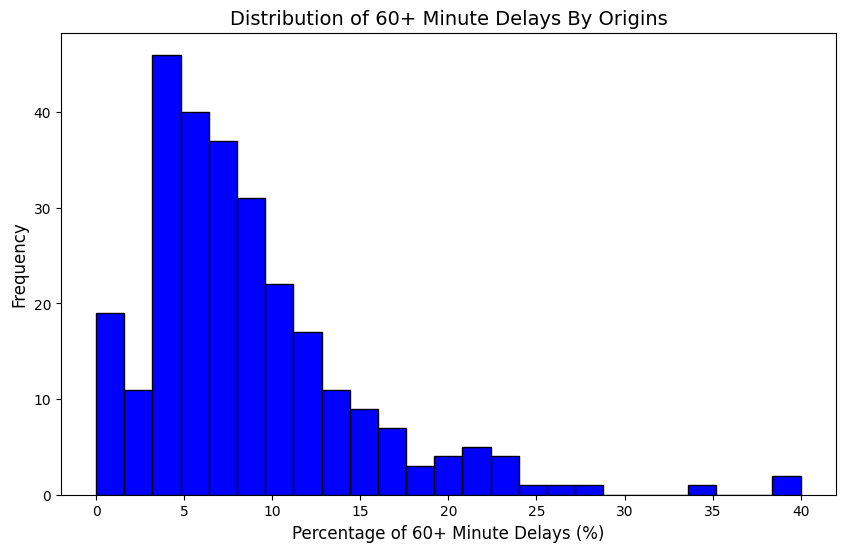

In [47]:
# Plot histogram
plt.figure(figsize=(10, 6))
plt.hist(pct_delay_by_origin.values, bins=25, color='blue', edgecolor='black')

# Add labels and title
plt.title("Distribution of 60+ Minute Delays By Origins", fontsize=14)
plt.xlabel("Percentage of 60+ Minute Delays (%)", fontsize=12)
plt.ylabel("Frequency", fontsize=12)

# Show the plot
plt.show()

# Handling Imbalanced data with Balanced Random forst Classifier

Classification Report (With SMOTE):
              precision    recall  f1-score   support

           0       0.95      0.83      0.88    134383
           1       0.18      0.46      0.26     10983

    accuracy                           0.80    145366
   macro avg       0.56      0.65      0.57    145366
weighted avg       0.89      0.80      0.84    145366

ROC AUC Score (With SMOTE): 0.7259695686380914


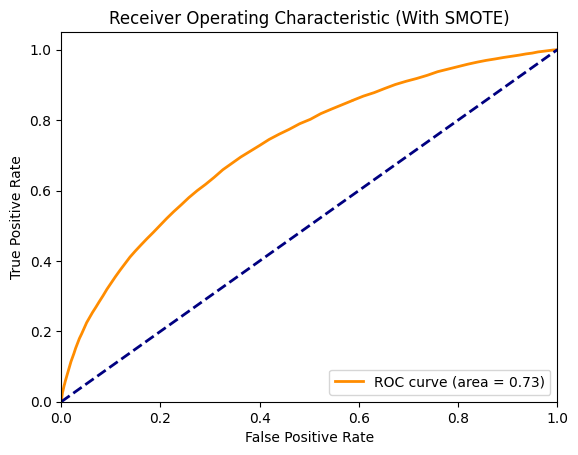

In [48]:
from imblearn.ensemble import BalancedRandomForestClassifier

# Split dataset into training and testing sets
#X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# Applying SMOTE
classifier = BalancedRandomForestClassifier(random_state=42)
classifier.fit(X_train, y_train)

# Predict test set
y_pred_brf = classifier.predict(X_test)
y_proba_brf = classifier.predict_proba(X_test)[:, 1]

# Print classification report for SMOTE data
print("Classification Report (With SMOTE):")
print(classification_report(y_test, y_pred_brf))

# Print ROC AUC Score for SMOTE data
print("ROC AUC Score (With SMOTE):", roc_auc_score(y_test, y_proba_brf))

# Plotting ROC AUC Curve for SMOTE data
fpr_brf, tpr_brf, _ = roc_curve(y_test, y_proba_brf)
plt.figure()
plt.plot(fpr_brf, tpr_brf, color='darkorange', lw=2, label='ROC curve (area = %0.2f)' % roc_auc_score(y_test, y_proba_brf))
plt.plot([0, 1], [0, 1], color='navy', lw=2, linestyle='--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver Operating Characteristic (With SMOTE)')
plt.legend(loc="lower right")
plt.show()



# Initialize and Fit the XGBoost classifier (baseline model)

In [49]:
xgb_model = xgb.XGBClassifier(random_state=0,
                              eval_metric='logloss')

In [50]:
xgb_model

XGBClassifier(base_score=None, booster=None, callbacks=None,
              colsample_bylevel=None, colsample_bynode=None,
              colsample_bytree=None, device=None, early_stopping_rounds=None,
              enable_categorical=False, eval_metric='logloss',
              feature_types=None, feature_weights=None, gamma=None,
              grow_policy=None, importance_type=None,
              interaction_constraints=None, learning_rate=None, max_bin=None,
              max_cat_threshold=None, max_cat_to_onehot=None,
              max_delta_step=None, max_depth=None, max_leaves=None,
              min_child_weight=None, missing=nan, monotone_constraints=None,
              multi_strategy=None, n_estimators=None, n_jobs=None,
              num_parallel_tree=None, ...)

In [51]:
# Train the model
xgb_model.fit(X_train, y_train)

XGBClassifier(base_score=None, booster=None, callbacks=None,
              colsample_bylevel=None, colsample_bynode=None,
              colsample_bytree=None, device=None, early_stopping_rounds=None,
              enable_categorical=False, eval_metric='logloss',
              feature_types=None, feature_weights=None, gamma=None,
              grow_policy=None, importance_type=None,
              interaction_constraints=None, learning_rate=None, max_bin=None,
              max_cat_threshold=None, max_cat_to_onehot=None,
              max_delta_step=None, max_depth=None, max_leaves=None,
              min_child_weight=None, missing=nan, monotone_constraints=None,
              multi_strategy=None, n_estimators=None, n_jobs=None,
              num_parallel_tree=None, ...)

# Predict on the test set

In [52]:
y_pred = xgb_model.predict(X_test)

# Evaluate the model

In [53]:
print("XGBoost Classifier (Baseline):")
print(f"Accuracy: {accuracy_score(y_test, y_pred):.4f}")

XGBoost Classifier (Baseline):
Accuracy: 0.9248


In [54]:

# Confusion matrix
cm = confusion_matrix(y_test, y_pred)
cm

array([[134322,     61],
       [ 10871,    112]])

In [55]:
# Predict probabilities for the test set (to calculate AUC)
y_pred_proba = xgb_model.predict_proba(X_test)[:, 1]  # We need probabilities for the positive class

# Calculate the AUC score
auc_score = roc_auc_score(y_test, y_pred_proba)
print(f"AUC Score: {auc_score:.4f}")

AUC Score: 0.7135


In [57]:
# Predict test set
y_pred_brf = classifier.predict(X_test)
y_proba_brf = classifier.predict_proba(X_test)[:, 1]

# Print classification report for SMOTE data
print("Classification Report (With SMOTE):")
print(classification_report(y_test, y_pred_brf))

Classification Report (With SMOTE):
              precision    recall  f1-score   support

           0       0.95      0.83      0.88    134383
           1       0.18      0.46      0.26     10983

    accuracy                           0.80    145366
   macro avg       0.56      0.65      0.57    145366
weighted avg       0.89      0.80      0.84    145366



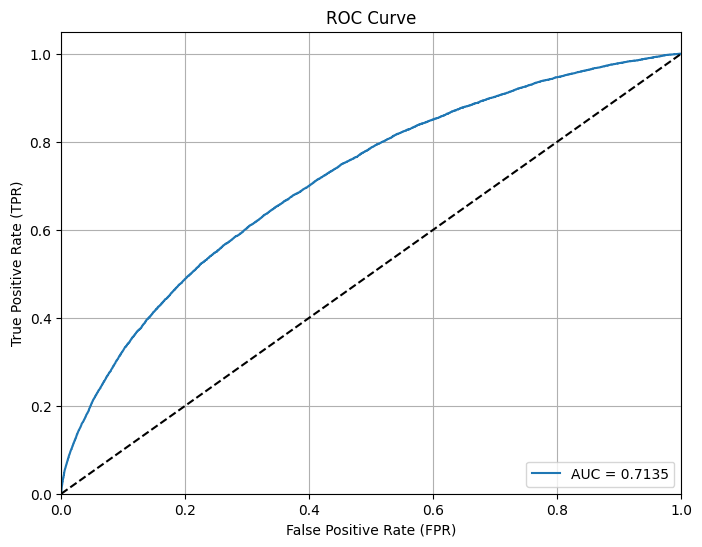

In [56]:
# Plot the ROC curve
fpr, tpr, thresholds = roc_curve(y_test, y_pred_proba)
plt.figure(figsize=(8, 6))
plt.plot(fpr, tpr, label=f'AUC = {auc_score:.4f}')
plt.plot([0, 1], [0, 1], 'k--')  # Diagonal line for random guessing
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate (FPR)')
plt.ylabel('True Positive Rate (TPR)')
plt.title('ROC Curve')
plt.legend(loc="lower right")
plt.grid(True)
plt.show()

# Do Cross-Validated Grid Search

In [58]:
# Define the parameter grid
param_grid = {
    'learning_rate': [0.01, 0.2],
    'max_depth': [3, 5, 7],
    'n_estimators': [100, 250],
    'subsample': [0.6,  1.0]
}

# Initialize the XGBoost model
xgb_model = xgb.XGBClassifier(random_state=0,
                              eval_metric='logloss')

# Set up GridSearchCV
grid_search = GridSearchCV(estimator=xgb_model,
                           param_grid=param_grid,
                           cv=3,
                           scoring='roc_auc',
                           verbose=1,
                           n_jobs=-1)

# Fit the grid search model
grid_search.fit(X_train, y_train)


Fitting 3 folds for each of 24 candidates, totalling 72 fits


GridSearchCV(cv=3,
             estimator=XGBClassifier(base_score=None, booster=None,
                                     callbacks=None, colsample_bylevel=None,
                                     colsample_bynode=None,
                                     colsample_bytree=None, device=None,
                                     early_stopping_rounds=None,
                                     enable_categorical=False,
                                     eval_metric='logloss', feature_types=None,
                                     feature_weights=None, gamma=None,
                                     grow_policy=None, importance_type=None,
                                     interaction_constraint...
                                     max_cat_to_onehot=None,
                                     max_delta_step=None, max_depth=None,
                                     max_leaves=None, min_child_weight=None,
                                     missing=nan, monotone_constraints=None,
                                     multi_strategy=None, n_estimators=None,
                                     n_jobs=None, num_parallel_tree=None, ...),
             n_jobs=-1,
             param_grid={'learning_rate': [0.01, 0.2], 'max_depth': [3, 5, 7],
                         'n_estimators': [100, 250], 'subsample': [0.6, 1.0]},
             scoring='roc_auc', verbose=1)

# Evaluate best parameters and predict on training set

In [59]:

# Best parameters from GridSearch
print("Best parameters found: ", grid_search.best_params_)

# Predict with the best model
y_pred_best = grid_search.best_estimator_.predict(X_test)

# Evaluate the tuned XGBoost model
print("XGBoost Classifier (Tuned):")
print(f"Accuracy: {accuracy_score(y_test, y_pred_best):.4f}")

Best parameters found:  {'learning_rate': 0.2, 'max_depth': 7, 'n_estimators': 250, 'subsample': 0.6}
XGBoost Classifier (Tuned):
Accuracy: 0.9246


In [60]:
# Confusion matrix
cm = confusion_matrix(y_test, y_pred_best)
cm

array([[134258,    125],
       [ 10839,    144]])

In [61]:
# Predict probabilities for the test set (to calculate AUC)
y_pred_proba = grid_search.best_estimator_.predict_proba(X_test)[:, 1]  # We need probabilities for the positive class

# Calculate the AUC score
auc_score = roc_auc_score(y_test, y_pred_proba)
print(f"AUC Score: {auc_score:.4f}")

AUC Score: 0.7202


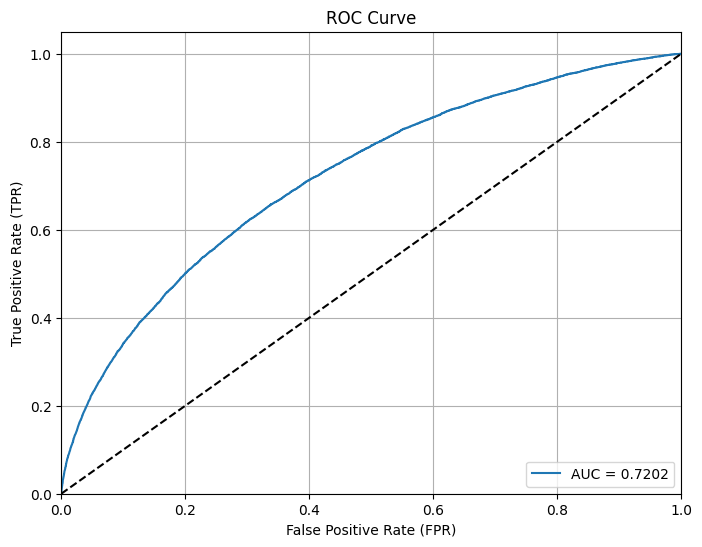

In [62]:
# Plot the ROC curve
fpr, tpr, thresholds = roc_curve(y_test, y_pred_proba)
plt.figure(figsize=(8, 6))
plt.plot(fpr, tpr, label=f'AUC = {auc_score:.4f}')
plt.plot([0, 1], [0, 1], 'k--')  # Diagonal line for random guessing
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate (FPR)')
plt.ylabel('True Positive Rate (TPR)')
plt.title('ROC Curve')
plt.legend(loc="lower right")
plt.grid(True)
plt.show()